
# Finetune Transformers Models with PyTorch Lightning

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-05-05T03:23:24.193004

This notebook will use HuggingFace's `datasets` library to get data, which will be wrapped in a `LightningDataModule`.
Then, we write a class to perform text classification on any dataset from the [GLUE Benchmark](https://gluebenchmark.com/).
(We just show CoLA and MRPC due to constraint on compute/disk)


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/text-transformers.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "datasets" "scikit-learn" "torchmetrics>=0.7" "scipy" "pytorch-lightning>=1.4" "torch>=1.8" "transformers" "torchtext>=0.9" "setuptools==59.5.0" "ipython[notebook]"

In [2]:
from datetime import datetime
from typing import Optional

import datasets
import torch
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from torch.utils.data import DataLoader
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

/usr/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Training BERT with Lightning

### Lightning DataModule for GLUE

In [3]:
class GLUEDataModule(LightningDataModule):

    task_text_field_map = {
        "cola": ["sentence"],
        "sst2": ["sentence"],
        "mrpc": ["sentence1", "sentence2"],
        "qqp": ["question1", "question2"],
        "stsb": ["sentence1", "sentence2"],
        "mnli": ["premise", "hypothesis"],
        "qnli": ["question", "sentence"],
        "rte": ["sentence1", "sentence2"],
        "wnli": ["sentence1", "sentence2"],
        "ax": ["premise", "hypothesis"],
    }

    glue_task_num_labels = {
        "cola": 2,
        "sst2": 2,
        "mrpc": 2,
        "qqp": 2,
        "stsb": 1,
        "mnli": 3,
        "qnli": 2,
        "rte": 2,
        "wnli": 2,
        "ax": 3,
    }

    loader_columns = [
        "datasets_idx",
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "start_positions",
        "end_positions",
        "labels",
    ]

    def __init__(
        self,
        model_name_or_path: str,
        task_name: str = "mrpc",
        max_seq_length: int = 128,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.model_name_or_path = model_name_or_path
        self.task_name = task_name
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size

        self.text_fields = self.task_text_field_map[task_name]
        self.num_labels = self.glue_task_num_labels[task_name]
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def setup(self, stage: str):
        self.dataset = datasets.load_dataset("glue", self.task_name)

        for split in self.dataset.keys():
            self.dataset[split] = self.dataset[split].map(
                self.convert_to_features,
                batched=True,
                remove_columns=["label"],
            )
            self.columns = [c for c in self.dataset[split].column_names if c in self.loader_columns]
            self.dataset[split].set_format(type="torch", columns=self.columns)

        self.eval_splits = [x for x in self.dataset.keys() if "validation" in x]

    def prepare_data(self):
        datasets.load_dataset("glue", self.task_name)
        AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def train_dataloader(self):
        return DataLoader(self.dataset["train"], batch_size=self.train_batch_size, shuffle=True)

    def val_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["validation"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def test_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["test"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def convert_to_features(self, example_batch, indices=None):

        # Either encode single sentence or sentence pairs
        if len(self.text_fields) > 1:
            texts_or_text_pairs = list(zip(example_batch[self.text_fields[0]], example_batch[self.text_fields[1]]))
        else:
            texts_or_text_pairs = example_batch[self.text_fields[0]]

        # Tokenize the text/text pairs
        features = self.tokenizer.batch_encode_plus(
            texts_or_text_pairs, max_length=self.max_seq_length, pad_to_max_length=True, truncation=True
        )

        # Rename label to labels to make it easier to pass to model forward
        features["labels"] = example_batch["label"]

        return features

**You could use this datamodule with standalone PyTorch if you wanted...**

In [4]:
dm = GLUEDataModule("distilbert-base-uncased")
dm.prepare_data()
dm.setup("fit")
next(iter(dm.train_dataloader()))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /home/AzDevOps_azpcontainer/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

{'input_ids': tensor([[  101,  2019,  2248,  ...,     0,     0,     0],
         [  101, 12631,  8002,  ...,     0,     0,     0],
         [  101,  1996,  1057,  ...,     0,     0,     0],
         ...,
         [  101,  1000,  2023,  ...,     0,     0,     0],
         [  101, 24471, 11246,  ...,     0,     0,     0],
         [  101,  1996, 17235,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
         0, 0, 1, 1, 0, 1, 1, 1])}

### Transformer LightningModule

In [5]:
class GLUETransformer(LightningModule):
    def __init__(
        self,
        model_name_or_path: str,
        num_labels: int,
        task_name: str,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        eval_splits: Optional[list] = None,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.config = AutoConfig.from_pretrained(model_name_or_path, num_labels=num_labels)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=self.config)
        self.metric = datasets.load_metric(
            "glue", self.hparams.task_name, experiment_id=datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
        )

    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        val_loss, logits = outputs[:2]

        if self.hparams.num_labels > 1:
            preds = torch.argmax(logits, axis=1)
        elif self.hparams.num_labels == 1:
            preds = logits.squeeze()

        labels = batch["labels"]

        return {"loss": val_loss, "preds": preds, "labels": labels}

    def validation_epoch_end(self, outputs):
        if self.hparams.task_name == "mnli":
            for i, output in enumerate(outputs):
                # matched or mismatched
                split = self.hparams.eval_splits[i].split("_")[-1]
                preds = torch.cat([x["preds"] for x in output]).detach().cpu().numpy()
                labels = torch.cat([x["labels"] for x in output]).detach().cpu().numpy()
                loss = torch.stack([x["loss"] for x in output]).mean()
                self.log(f"val_loss_{split}", loss, prog_bar=True)
                split_metrics = {
                    f"{k}_{split}": v for k, v in self.metric.compute(predictions=preds, references=labels).items()
                }
                self.log_dict(split_metrics, prog_bar=True)
            return loss

        preds = torch.cat([x["preds"] for x in outputs]).detach().cpu().numpy()
        labels = torch.cat([x["labels"] for x in outputs]).detach().cpu().numpy()
        loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log_dict(self.metric.compute(predictions=preds, references=labels), prog_bar=True)

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]

## Training

### CoLA

See an interactive view of the
CoLA dataset in [NLP Viewer](https://huggingface.co/nlp/viewer/?dataset=glue&config=cola)

In [6]:
seed_everything(42)

dm = GLUEDataModule(model_name_or_path="albert-base-v2", task_name="cola")
dm.setup("fit")
model = GLUETransformer(
    model_name_or_path="albert-base-v2",
    num_labels=dm.num_labels,
    eval_splits=dm.eval_splits,
    task_name=dm.task_name,
)

trainer = Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
)
trainer.fit(model, datamodule=dm)

Global seed set to 42


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /home/AzDevOps_azpcontainer/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


  0%|          | 0/3 [00:00<?, ?it/s]

Missing logger folder: /__w/1/s/lightning_logs


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Loading `train_dataloader` to estimate number of stepping batches.


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

  | Name  | Type                            | Params
----------------------------------------------------------
0 | model | AlbertForSequenceClassification | 11.7 M
----------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.740    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### MRPC

See an interactive view of the
MRPC dataset in [NLP Viewer](https://huggingface.co/nlp/viewer/?dataset=glue&config=mrpc)

In [7]:
seed_everything(42)

dm = GLUEDataModule(
    model_name_or_path="distilbert-base-cased",
    task_name="mrpc",
)
dm.setup("fit")
model = GLUETransformer(
    model_name_or_path="distilbert-base-cased",
    num_labels=dm.num_labels,
    eval_splits=dm.eval_splits,
    task_name=dm.task_name,
)

trainer = Trainer(
    max_epochs=3,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
)
trainer.fit(model, datamodule=dm)

Global seed set to 42


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Loading `train_dataloader` to estimate number of stepping batches.


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

  | Name  | Type                                | Params
--------------------------------------------------------------
0 | model | DistilBertForSequenceClassification | 65.8 M
--------------------------------------------------------------
65.8 M    Trainable params
0         Non-trainable params
65.8 M    Total params
263.132   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### MNLI

 - The MNLI dataset is huge, so we aren't going to bother trying to train on it here.
 - We will skip over training and go straight to validation.

See an interactive view of the
MRPC dataset in [NLP Viewer](https://huggingface.co/nlp/viewer/?dataset=glue&config=mnli)

In [8]:
dm = GLUEDataModule(
    model_name_or_path="distilbert-base-cased",
    task_name="mnli",
)
dm.setup("fit")
model = GLUETransformer(
    model_name_or_path="distilbert-base-cased",
    num_labels=dm.num_labels,
    eval_splits=dm.eval_splits,
    task_name=dm.task_name,
)

trainer = Trainer(
    max_epochs=3,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
)
trainer.validate(model, dm)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /home/AzDevOps_azpcontainer/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?ba/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     accuracy_matched      │    0.3181864619255066     │    0.3181864619255066     │
│    accuracy_mismatched    │    0.3182465434074402     │    0.3182465434074402     │
│     val_loss_matched      │    1.1081156730651855     │    1.1081156730651855     │
│    val_loss_mismatched    │    1.1085437536239624     │    1.1085437536239624     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_loss_matched': 1.1081156730651855,
  'accuracy_matched': 0.3181864619255066,
  'val_loss_mismatched': 1.1085437536239624,
  'accuracy_mismatched': 0.3182465434074402},
 {'val_loss_matched': 1.1081156730651855,
  'accuracy_matched': 0.3181864619255066,
  'val_loss_mismatched': 1.1085437536239624,
  'accuracy_mismatched': 0.3182465434074402}]

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[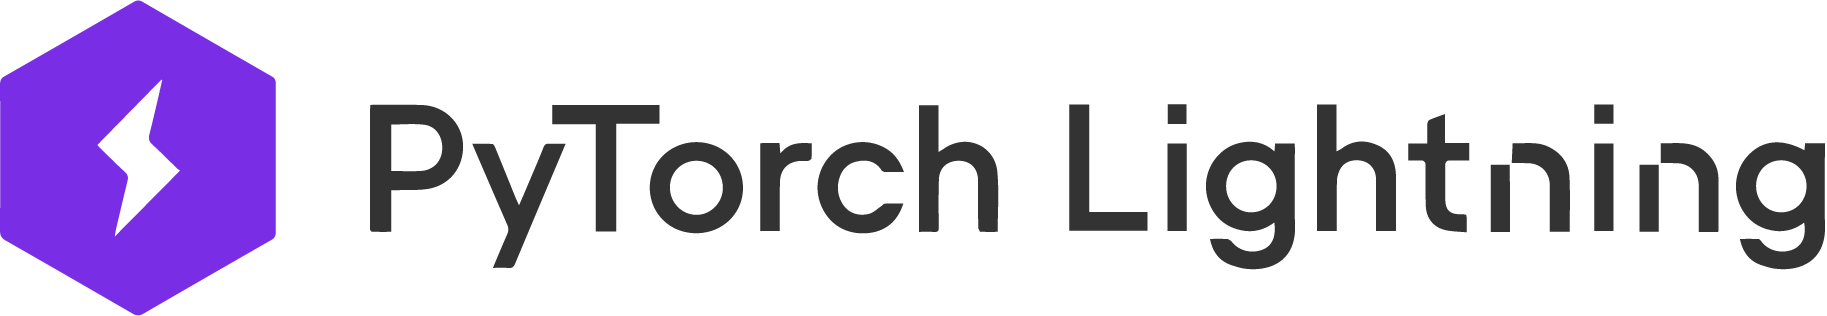{height="60px" width="240px"}](https://pytorchlightning.ai)